## Exercise 2.11

Conduct a parameter exploration exercise on a 10-armed bandit testbed in a nonstationary case. Include the following strategies for the agent:

- $\epsilon$-greedy algorithm with constant step size $\alpha = 0.1$ - Explore for $\epsilon$
- Upper Confidence Bound (UCB) - Explore for $c$
- Gradient Bandit algorithm - Explore for $\alpha$
- Optimistic Initialization - Explore for $Q_0$

Results should be delivered following this schema: run a single episode and run the algorithm for 200,000 steps. Then compute the average reward from the step n. 100,000 for each parameter setting.

In [1]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import time

In [2]:
class Bandit():

    def __init__(self, n_bandits, max_steps):
        self.n_bandits = n_bandits
        self.max_steps = max_steps

        self.dev_reward = 1
        self.randomwalk_mean = 0
        self.randomwalk_std = 0.01

        self.reset()

    
    def reset(self):
        self.action_history = []
        self.mean_reward_per_step = np.zeros(self.max_steps)
        self.optimal_reward_per_step = np.zeros(self.max_steps)
        self.median_reward_per_step = np.zeros(self.max_steps)
        self.optimal_action_pct = np.zeros(self.max_steps)
        self.n_optimal_actions = 0
        self.total_reward = 0
        self.opt_total_reward = 0
        self.median_total_reward = 0
        self.q_stars = np.zeros(self.n_bandits)
        self.curr_steps = 0
        self.done = False

    
    def step(self, action):
        # Update number of steps
        self.curr_steps += 1
        
        self.action_history.append(action)
        
        # Updating action values
        self.q_stars += np.random.normal(self.randomwalk_mean, self.randomwalk_std, self.q_stars.shape[0])
        
        # Searching for optimal and median actions
        opt_action = np.argmax(self.q_stars)
        median_action = np.argsort(self.q_stars)[len(self.q_stars)//2]
        opt_act_value = self.q_stars[opt_action]
        act_value = self.q_stars[action]
        median_act_value = self.q_stars[median_action]
        
        # Update Optimal Action Counting
        if act_value == opt_act_value:
            self.n_optimal_actions +=1
        self.optimal_action_pct[self.curr_steps-1] = self.n_optimal_actions/self.curr_steps

        # Computing Reward and appending to reward list
        reward = np.random.normal(act_value, self.dev_reward)
        self.total_reward += reward
        self.mean_reward_per_step[self.curr_steps-1] = self.total_reward/self.curr_steps
        
        # Computing Optimal Reward and appending to optimal reward list
        opt_reward = np.random.normal(opt_act_value, self.dev_reward)
        self.opt_total_reward += opt_reward
        self.optimal_reward_per_step[self.curr_steps-1] = self.opt_total_reward/self.curr_steps
        
        # Computing Worst Reward and appending to optimal reward list
        median_reward = np.random.normal(median_act_value, self.dev_reward)
        self.median_total_reward += median_reward
        self.median_reward_per_step[self.curr_steps-1] = self.median_total_reward/self.curr_steps
        
        msg = f"Selected Action: {action} | Optimal action: {opt_action} | true_value : {act_value} | optimal_value: {opt_act_value}"
        #print(msg)

        if self.curr_steps == self.max_steps:
            self.done = True
            
        return reward, self.done

    
    def plot_results(self):
        fig, axes = plt.subplots(2, 1, figsize=(20, 20))

        axes[0].plot(self.mean_reward_per_step, label="Mean reward achieved")
        axes[0].plot(self.optimal_reward_per_step, label="Optimal reward achievable")
        axes[0].plot(self.median_reward_per_step, label="Median reward achievable")
        axes[0].set_xlabel("Steps")
        axes[0].set_ylabel("Average Reward")
        axes[0].set_title("Mean Reward per step")
        axes[0].legend()
        

        axes[1].plot(np.array(self.optimal_action_pct)*100, label="Optimal Action Percentage")
        axes[1].set_xlabel("Steps")
        axes[1].set_ylabel("% of Optimal Actions")
        axes[1].set_title("% of Optimal Actions per step")
        axes[1].legend()
            

    def get_results(self):
        return self.mean_reward_per_step, self.optimal_action_pct

In [3]:
class Agent():
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.reset()


    def reset(self):
        self.initialize_estimates_()

    
    def initialize_estimates_(self):
        estimates = []
        for i in range(self.n_actions):
            estimates.append((np.random.normal(0, 1), 0))
        self.action_estimates = estimates

    
    def choose_action(self, step):
        pass
        

    def update_action(self, action, reward, step):
        pass

In [4]:
class ExponentialWeightedAgent(Agent):

    def __init__(self, n_actions, epsilon):
        super().__init__(n_actions)
        self.epsilon = epsilon
        self.alfa = 0.1
    
    def choose_action(self, step):
        rand_number = np.random.uniform()
        if rand_number < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            values = [val for val, n in self.action_estimates]
            return np.argmax(values)

    def update_action(self, action, reward, step):
        value, n_action = self.action_estimates[action]
        value += self.alfa * (reward - value)
           
        self.action_estimates[action] = (value, n_action+1)

In [5]:
class UpperConfidenceBoundAgent(Agent):

    def __init__(self, n_actions, c):
        super().__init__(n_actions)
        self.alfa = 0.1
        self.c = c
    
    def choose_action(self, step):
        estimated_vals = []
        for val, n in self.action_estimates:
            if n <= 0:
                new_val = np.inf
            else:
                new_val = val + self.c*np.sqrt(np.log(step)/n)
                    
            estimated_vals.append(new_val)

        return np.argmax(estimated_vals)

    def update_action(self, action, reward, step):
        value, n_action = self.action_estimates[action]
        value += self.alfa * (reward - value)
           
        self.action_estimates[action] = (value, n_action+1)

In [6]:
class GradientBanditAgent:

    def __init__(self, n_actions, gamma):
        self.n_actions = n_actions
        self.alfa = 0.1
        self.gamma = gamma
        self.baseline = 0
        self.reset()


    def reset(self):
        self.initialize_estimates_()

    
    def initialize_estimates_(self):
        estimates = []
        for i in range(self.n_actions):
            # Preference Value, number of selections
            estimates.append((0, 0))
        self.action_estimates = estimates
    
    
    def get_probabilities(self, preferences):
        exp_prefs = np.exp(preferences)
        return exp_prefs / np.sum(exp_prefs)
    
    
    def choose_action(self, step):
        preferences = [pref for pref, _ in self.action_estimates ]
        prob_preferences = self.get_probabilities(preferences)
        action = np.random.choice(self.n_actions, p=prob_preferences)
        return action

    
    def update_action(self, action, reward, step):
        n_actions = [n for pref, n in self.action_estimates ]
        preferences = [pref for pref, n in self.action_estimates ]
        prob_preferences = self.get_probabilities(preferences)
        
        # Update the baseline
        self.baseline += self.alfa * (reward - self.baseline)
        
        for idx, items in enumerate(zip(preferences, n_actions, prob_preferences)):
            pref, n, prob = items
            if idx == action:
                msg = f"CHOSEN action: {action}, baseline: {self.baseline}, obatined_reward: {reward}, diff:{reward-self.baseline}, update_on_action:{self.gamma * (reward - self.baseline) * (1 - prob)}"
                #print(msg)
                updated_pref = pref + self.gamma * (reward - self.baseline) * (1 - prob)
                self.action_estimates[idx] = (updated_pref, n+1)
            else:
                msg = f"action: {idx}, baseline: {self.baseline}, obatined_reward: {reward}, diff:{reward-self.baseline}, update_on_action:{-self.gamma * (reward - self.baseline) * prob}"
                #print(msg)
                updated_pref = pref - self.gamma * (reward - self.baseline) * prob
                self.action_estimates[idx] = (updated_pref, n)
                

In [16]:
def play_one_episode(env, agent):
    np.random.seed(42)
    env.reset()
    agent.reset()
    done = False
    
    selected_actions = []
    optimal_actions = []
    test = []
    counter_test = []
    action_to_explore = 0
    while not env.done:
        action = agent.choose_action(env.curr_steps)
        selected_actions.append(action)
        optimal_actions.append(np.argmax(env.q_stars))
        
        
        test.append(agent.action_estimates[action_to_explore][0])
        counter_test.append(env.q_stars[action_to_explore])
        
        reward, done = env.step(action)
        agent.update_action(action, reward, env.curr_steps)
        #time.sleep(0.0001)
    
    #plt.plot(selected_actions, label="selected")
    #plt.plot(optimal_actions, label="optimal")
    plt.plot(test, label=f"action estimate {action_to_explore}")
    plt.plot(counter_test, label=f"action value {action_to_explore}")
    plt.legend()
    return env.get_results()

In [17]:
n_bandits = 10
n_steps = 50000
n_runs = 100

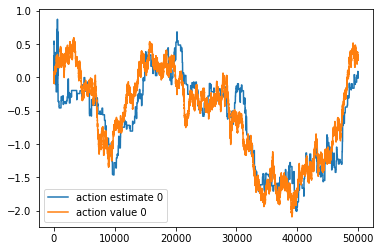

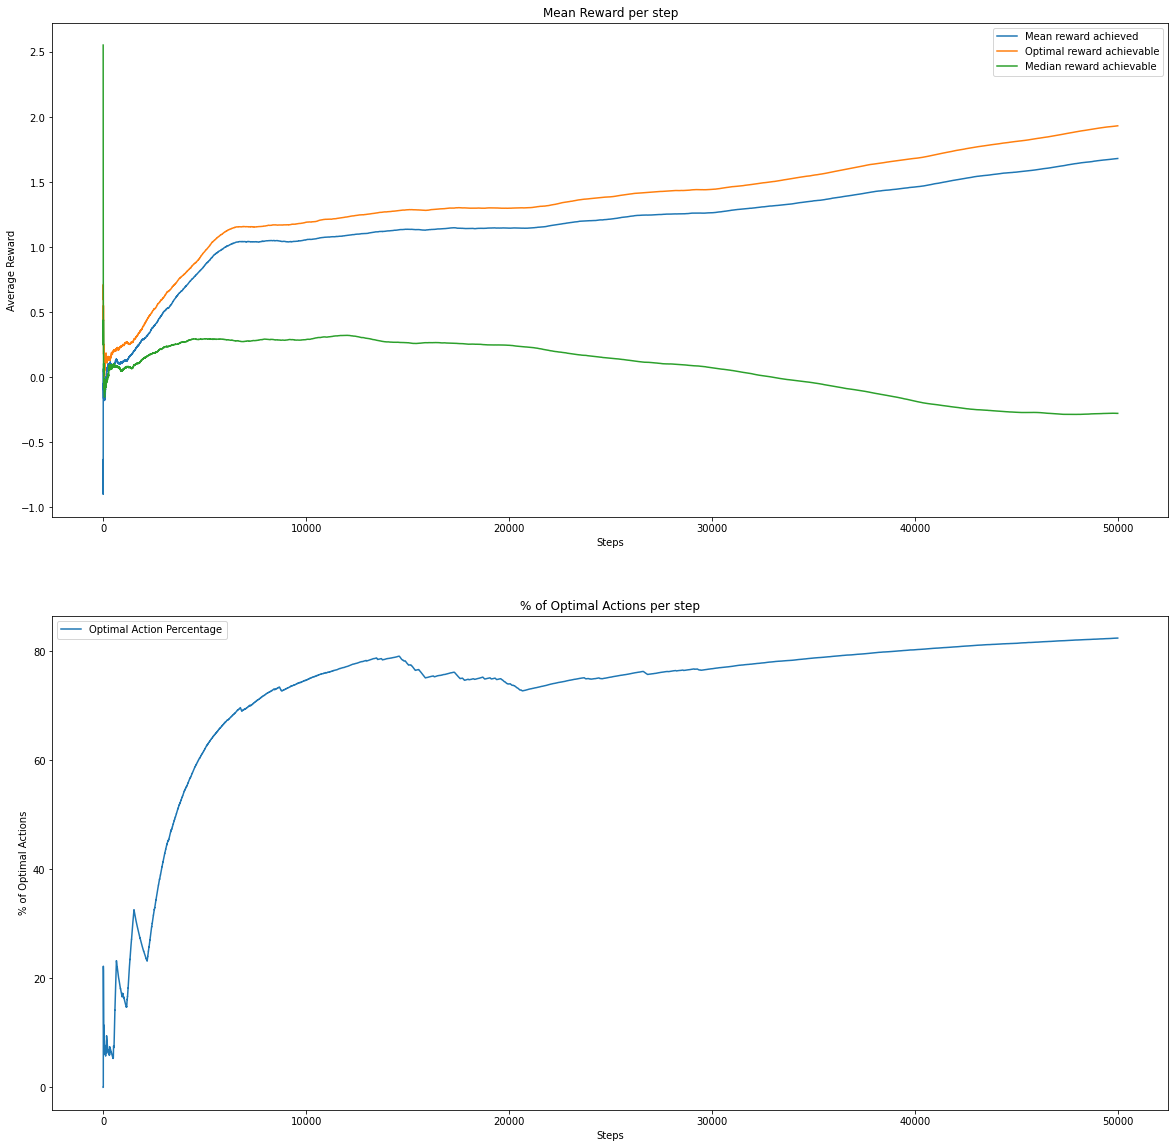

In [18]:
env = Bandit(n_bandits, n_steps)
agent = ExponentialWeightedAgent(n_bandits, epsilon=0.1)
_ = play_one_episode(env, agent)
env.plot_results()

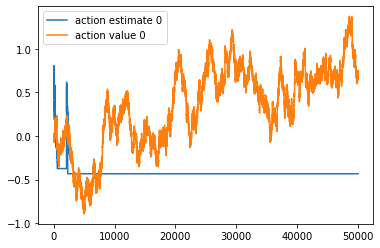

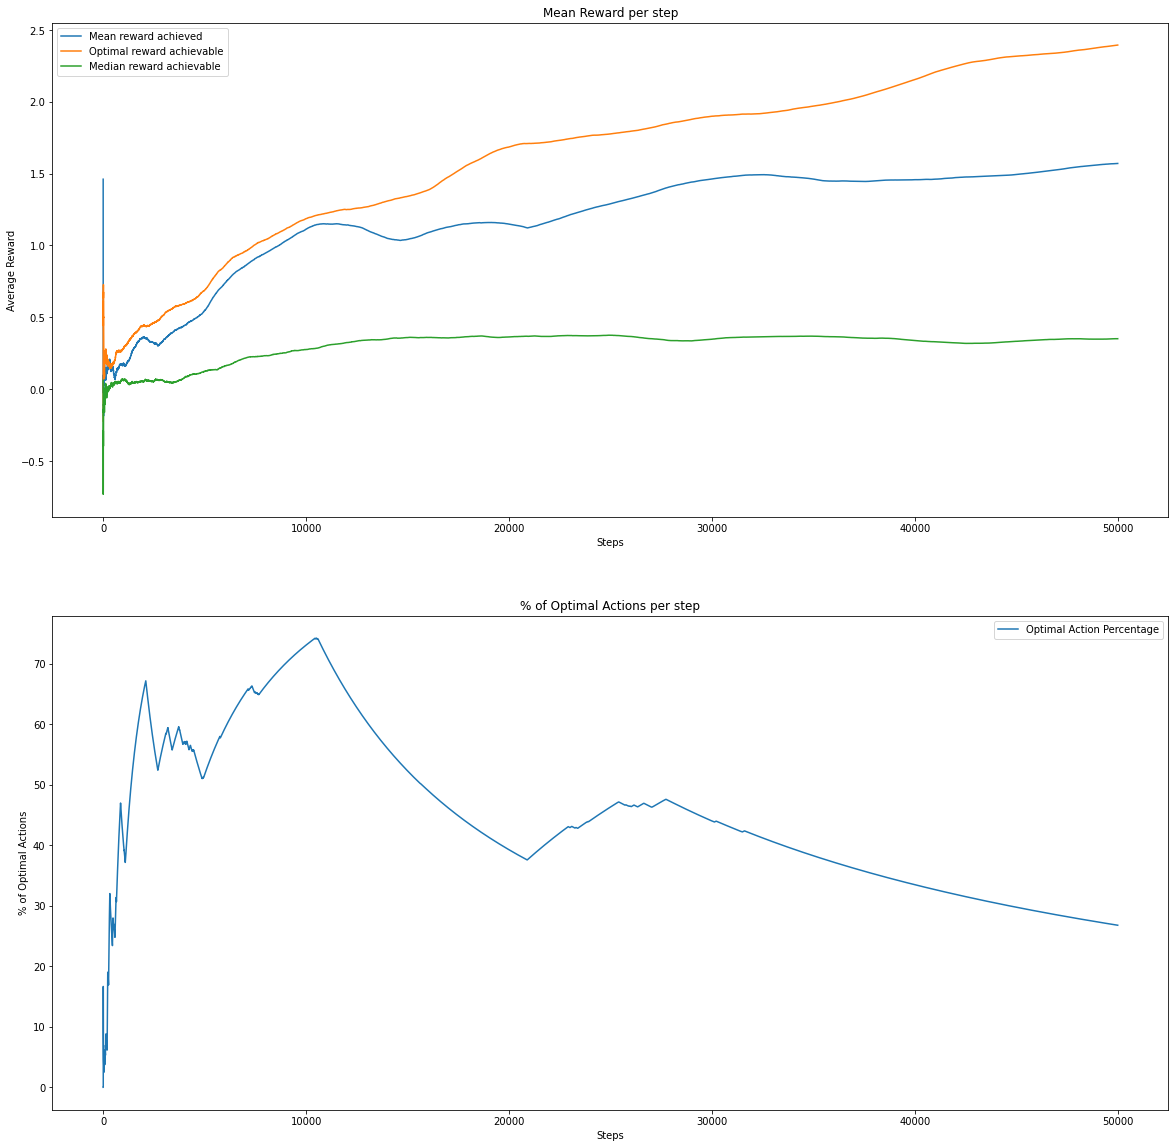

In [19]:
env = Bandit(n_bandits, n_steps)
agent = UpperConfidenceBoundAgent(n_bandits, c=0.75)
_ = play_one_episode(env, agent)
env.plot_results()

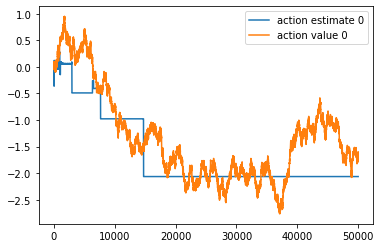

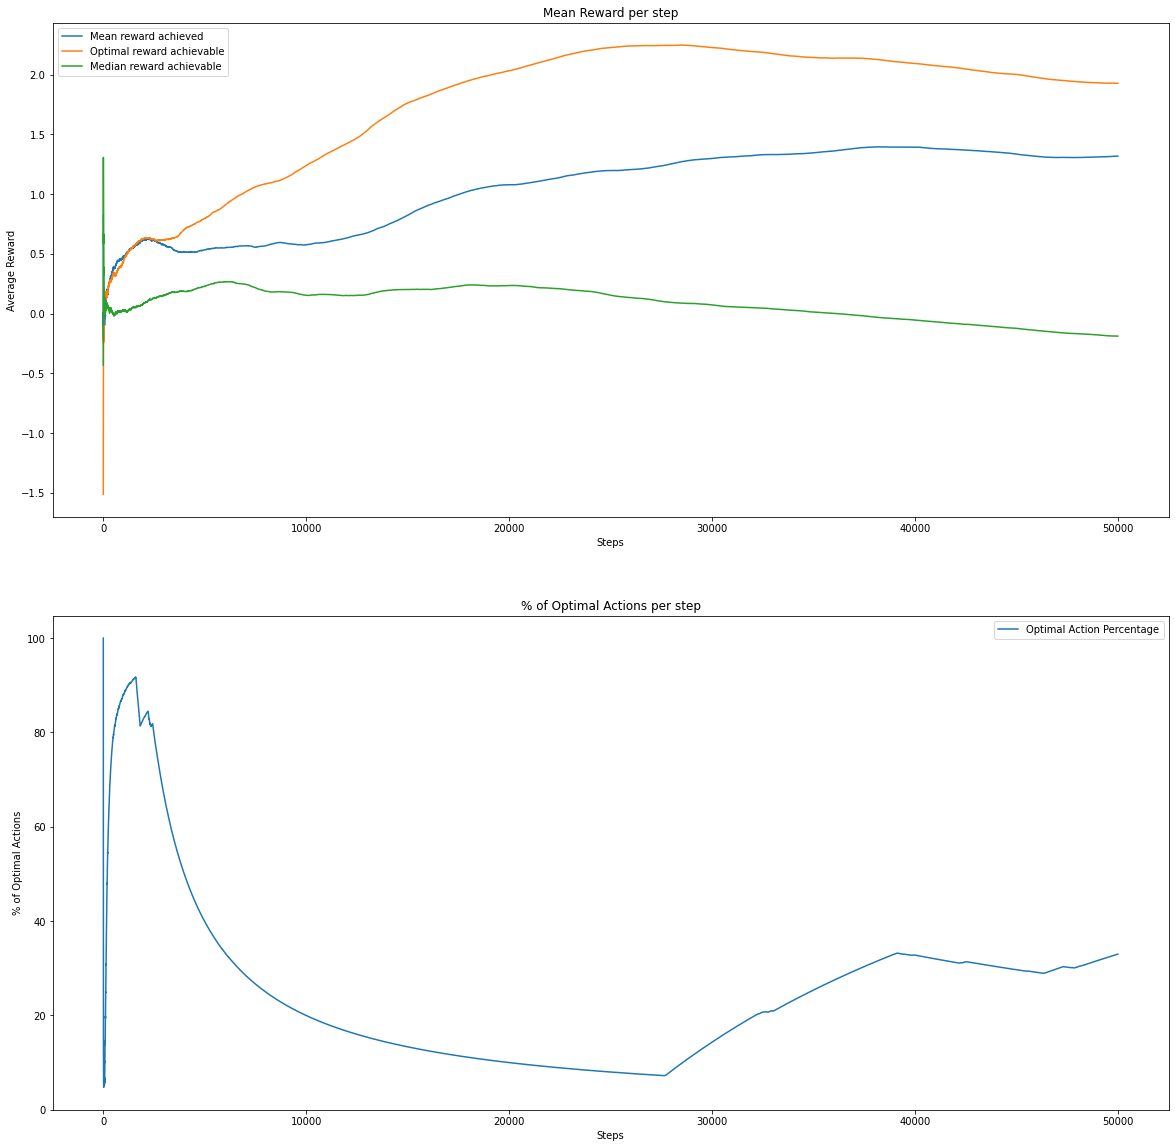

In [20]:
env = Bandit(n_bandits, n_steps)
agent = GradientBanditAgent(n_bandits, gamma=0.25)
_ = play_one_episode(env, agent)
env.plot_results()